# Test Notebook for solvers Algorithms

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

# Operator imports
import ndoperators as ops
import llops as yp

# Libwallerlab imports
from ndoperators import solvers
from ndoperators.solvers import objectivefunctions, regularizers

In [2]:
ops.setDefaultBackend('arrayfire') # arrayfire or numpy
ops.setDefaultDatatype('float32')

global_dtype = yp.config.default_dtype
global_backend = yp.config.default_backend

# Generate Forward Model For Convolutional System with Windowing

/Users/zfphil/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


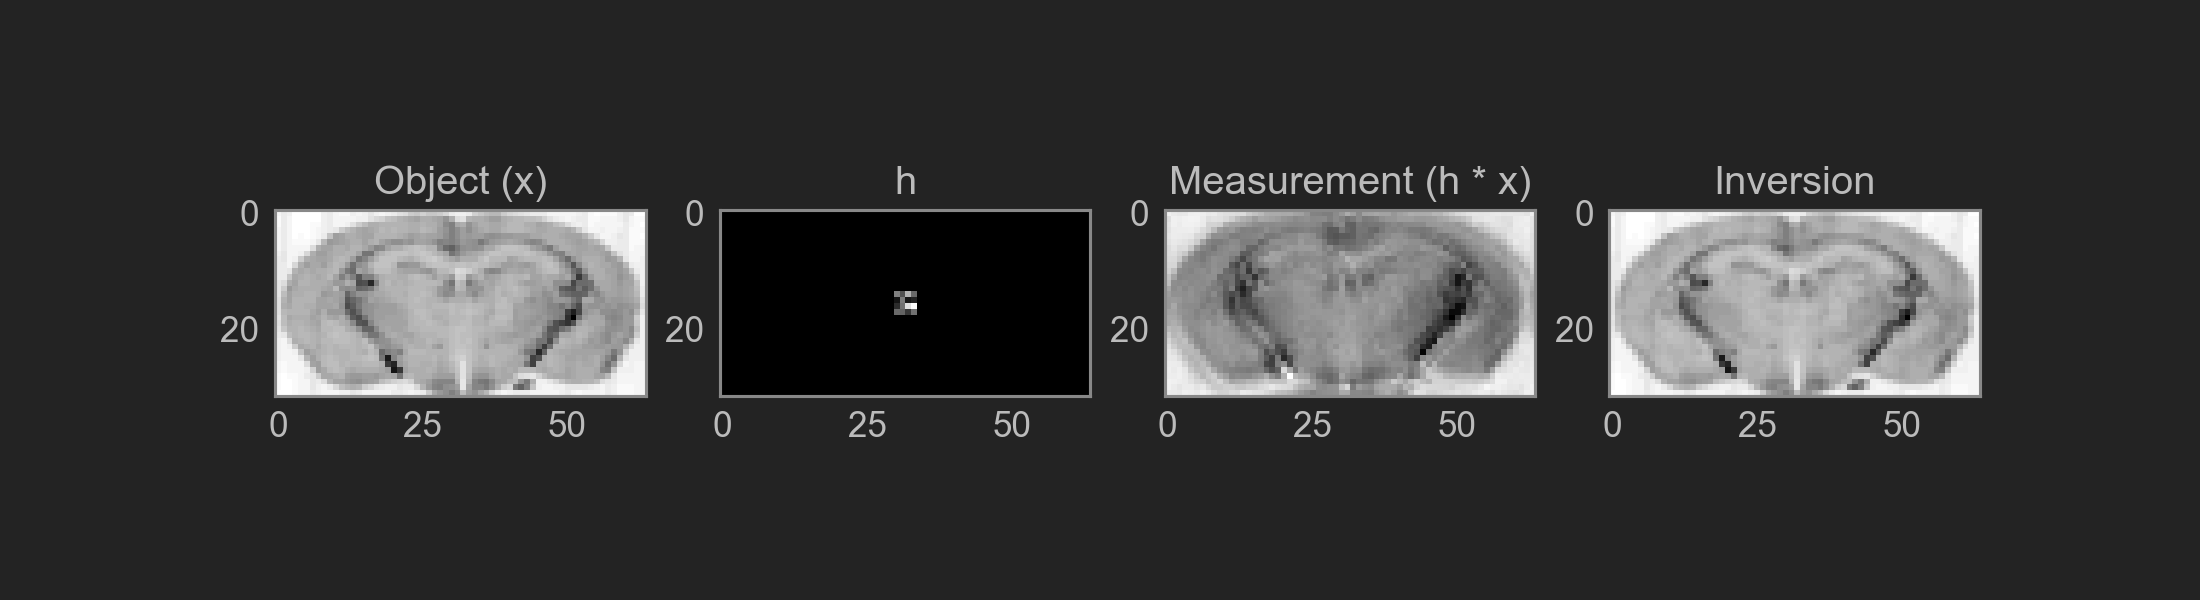

In [16]:
# Image to use when generating object
object_file_name = '../test/brain_to_scan.png'

# Color channel to use when generating object
object_color_channel = 2

# Image size to simulate
image_size = np.array([32, 64])

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Load object and crop to size
brain = imageio.imread(object_file_name)
x_0 = np.asfortranarray(sp.misc.imresize(brain, size=image_size)[:, :, object_color_channel].astype(yp.getNativeDatatype(global_dtype, 'numpy')) / 255.)

# Convert object to global default backend
x = yp.changeBackend(x_0)
object_true =x

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(yp.abs(h)))

C = ops.Convolution(h, pad_value='mean')
A = C
y = A * x

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(141)
plt.imshow(yp.abs(yp.changeBackend(x_0, 'numpy')))
plt.title('Object (x)')
plt.subplot(142)
plt.imshow(yp.abs(np.asarray(h)))
plt.title('h')
plt.subplot(143)
plt.imshow((yp.abs(np.asarray(y))))
plt.title('Measurement (h * x)');
plt.subplot(144)
plt.imshow((yp.abs(np.asarray(A.inv * y))))
plt.title('Inversion');

# Reconstructions

## L2 Objective

In [17]:
# Generate Objective
objective = objectivefunctions.L2(A, y)

# Generate Object
x = yp.ones(objective.N, global_dtype, global_backend)

# Render latex
objective.latex()

<IPython.core.display.Latex object>

### Gradient Descent

<IPython.core.display.Javascript object>


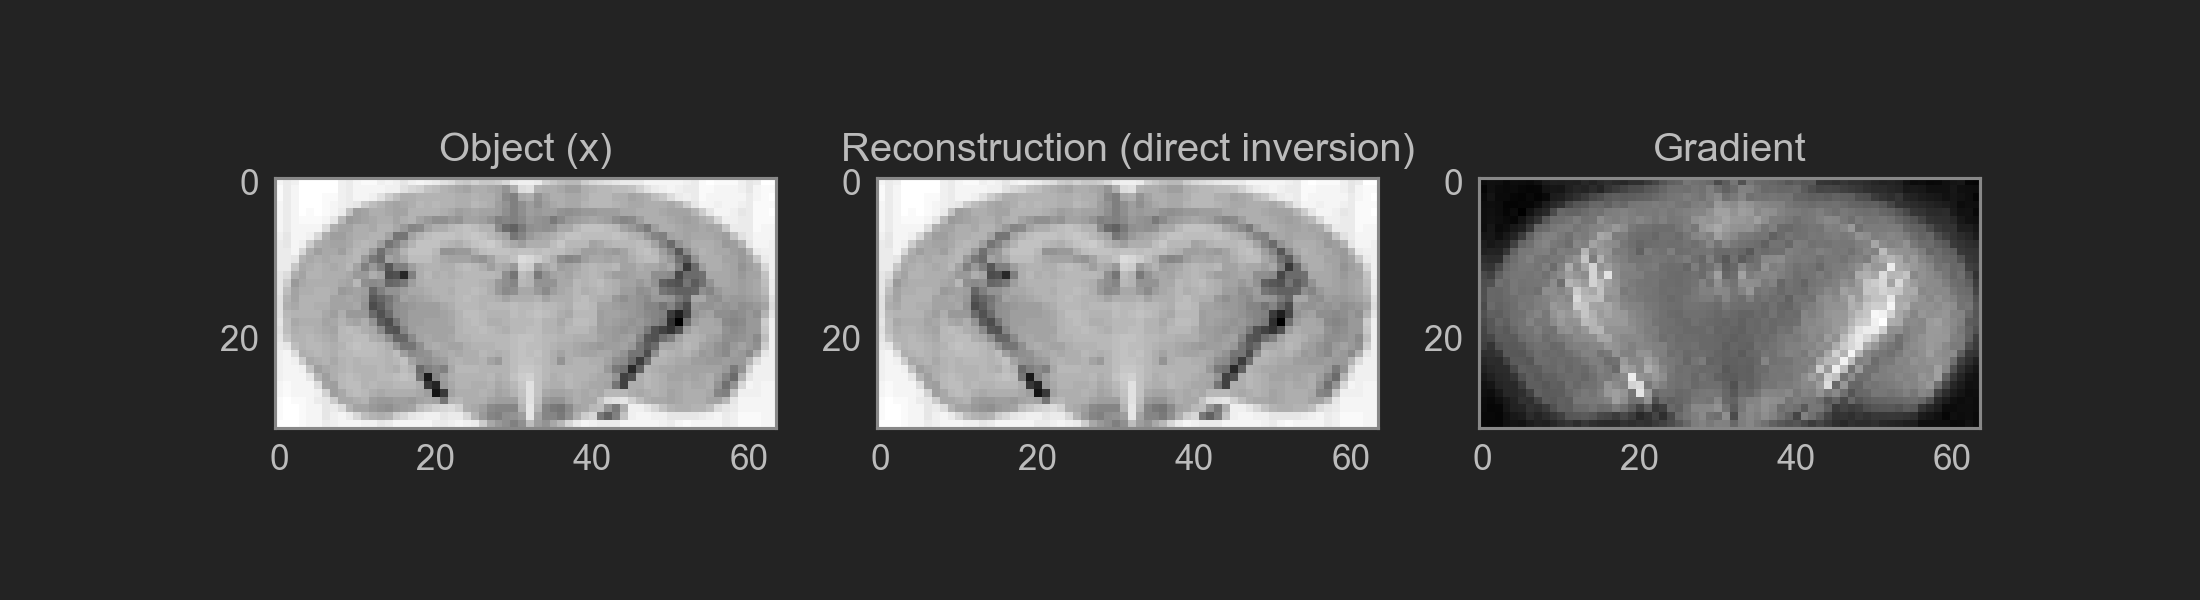

In [18]:
# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(np.asarray(object_true)), cmap='gray')
plt.title('Object (x)')
plt.subplot(132)
plt.imshow(np.abs(A.inv * y), cmap='gray')
plt.title('Reconstruction (direct inversion)')
plt.subplot(133)
plt.imshow(yp.abs(objective.gradient(x)), cmap='gray')
plt.title('Gradient');

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    1.10e+02    |       0.00       |    0.00e+00    |  278.1 MB /    0.2 MB  |
|   50   |    5.63e-04    |       1.00       |    2.43e-03    |  278.2 MB /    0.2 MB  |
|  100   |    4.82e-05    |       1.90       |    9.54e-05    |  278.2 MB /    0.2 MB  |
|  150   |    1.15e-05    |       2.81       |    6.48e-05    |  278.2 MB /    0.2 MB  |
|  200   |    5.06e-06    |       3.75       |    1.91e-05    |  278.2 MB /    0.2 MB  |
|  250   |    1.85e-06    |       4.66       |    3.81e-06    |  278.2 MB /    0.2 MB  |
|  300   |    1.28e-06    |       5.57       |    7.63e-06    |  278.2 MB /    0.2 MB  |
|  350   |    7.09e-07    |       6.46       |    1.91e-05    |  278.2 MB /    0.2 MB  |
|  400   |    3.51e-07    |       7.41       |    1.91e-05    |  278.2 MB /    0.2 MB  |
|  450   |    1.61e-0

<IPython.core.display.Javascript object>


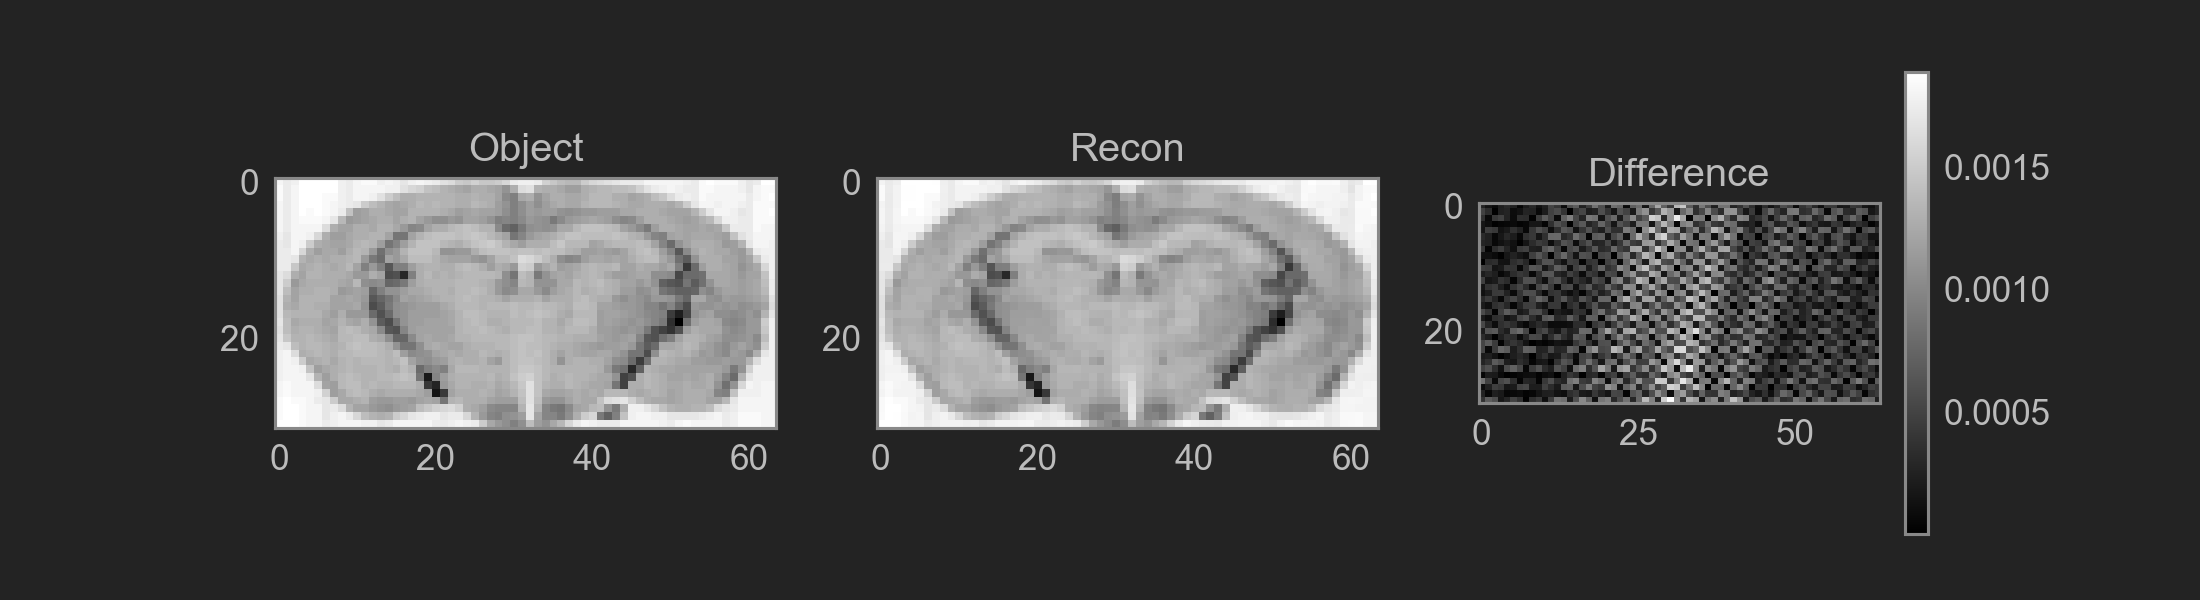

In [19]:

x_opt = solvers.GradientDescent(objective).solve(iteration_count=200, display_type='text', step_size=0.1, display_iteration_delta=50, 
                                                use_nesterov_acceleration=True, nesterov_restart_enabled=True)
# Show object and psf
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(132)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(133)
plt.imshow(np.abs(x_opt - object_true), cmap='gray')
plt.title('Difference')
plt.colorbar()

## Conjugate Gradient

In [21]:
x_opt = solvers.ConjugateGradient(A, y).solve(iteration_count=50, display_type='text', step_size=0.1, display_iteration_delta=5)

# Show object and psf
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(132)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(133)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    1.10e+02    |       0.00       |    0.00e+00    |  291.4 MB /    0.2 MB  |


RuntimeError: In function af::dim4 getOutDims(const af::dim4 &, const af::dim4 &, bool)
In file src/backend/common/ArrayInfo.cpp:180
Invalid dimension for argument 1
Expected: ldims == rdims


# ISTA/FISTA

In [22]:
# Define regularizer function
reg_type = 'fourier'
if reg_type is 'wavelet':
    reg = regularizers.WaveletSparsity(image_size, wavelet_type='haar')
    sparse_op = reg.sparse_op
elif reg_type is 'fourier':
    sparse_op = ops.FourierTransform(image_size)
    reg = ops.L1Norm(image_size) * sparse_op

# Generate objective function
objective_reg = objective + 1e-1 * reg

# Solve using FISTA/ISTA
x_opt = solvers.Fista(objective_reg).solve(iteration_count=500, display_type='text', step_size=0.1, display_iteration_delta=50, 
                                            normalize_step_size=True, use_nesterov_acceleration=False, nesterov_restart_enabled=False)

# Show object and psf
plt.figure(figsize=(12,3))
plt.subplot(141)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(142)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(143)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')
plt.subplot(144)
x_s = yp.changeBackend(sparse_op * x_opt, 'numpy')
x_s *= np.abs(x_s) > 1e-7
plt.imshow(np.log(np.abs(x_s).reshape(sparse_op.M)))
plt.title('Sparse Transform of Recon');

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +


IndexError: In function void assign(Array<T> &, const vector<af_seq>, const af_array &) [T = float]
In file src/api/c/assign.cpp:108
Invalid type for argument 1
